# Physionet Sepsis Dataset
要求提前6h预测；  
每一时刻有40个变量值，1个label；  
Label=1：sepsis onset 6h前  
采样间隔：1h  
每个sample的时间总长度不同

In [2]:
import io
import os
import re
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  
import create_folder as cf

In [5]:
# Set path
DATA_DIR="../raw_data"
CHECKDATA_DIR = '../data_information'
NEWDATA_DIR='../file_data'

In [6]:
# setA file
print('数据数量')
trainingA_files=[]
trainingA_files_dir=DATA_DIR+'/training_A/'
for file in os.listdir(trainingA_files_dir):
    sample_file=trainingA_files_dir+file
    trainingA_files.append(sample_file)
print (len(trainingA_files))

# setB file
trainingB_files=[]
trainingB_files_dir=DATA_DIR+'/training_B/'
for file in os.listdir(trainingB_files_dir):
    sample_file=trainingB_files_dir+file
    trainingB_files.append(sample_file)
print (len(trainingB_files))

# total set file
training_files=trainingA_files+trainingB_files
print (len(training_files))

数据数量
20336
20000
40336


In [7]:
# show one file content 
print('setA p000001 信息')
df=pd.read_csv(training_files[0],delimiter="|")
df.head()

setA p000001 信息


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,80.0,100.0,36.50,121.00,58.0,41.00,13.5,NaN,1.0,25.0,...,9.9,223.0,160.0,77.27,1,0,1,-69.14,3,0
1,76.0,100.0,36.25,113.25,61.0,41.50,12.0,NaN,1.0,25.0,...,9.9,NaN,NaN,77.27,1,0,1,-69.14,4,0
2,80.0,100.0,36.25,132.75,71.5,46.25,12.0,NaN,NaN,NaN,...,NaN,NaN,NaN,77.27,1,0,1,-69.14,5,0
3,78.0,100.0,36.10,103.50,58.0,43.00,12.0,NaN,-3.0,NaN,...,NaN,NaN,NaN,77.27,1,0,1,-69.14,6,0
4,74.0,100.0,36.00,128.75,69.5,44.50,12.5,NaN,-3.0,NaN,...,NaN,NaN,NaN,77.27,1,0,1,-69.14,7,0


In [41]:
# time length statistics
time_length_map={}
min_length=100
max_length=0
for file in training_files:
    df=pd.read_csv(file,delimiter="|")
    length=df.shape[0]
    if time_length_map.get(length):
        time_length_map[length]+=1
    else:  
        time_length_map[length]=1
    if length>max_length:
        max_length=length
    if length<min_length:
        min_length=length

In [46]:
print ('最长时间长度：'+str(max_length)+'；最短时间长度：'+str(min_length))

最长时间长度：336；最短时间长度：8


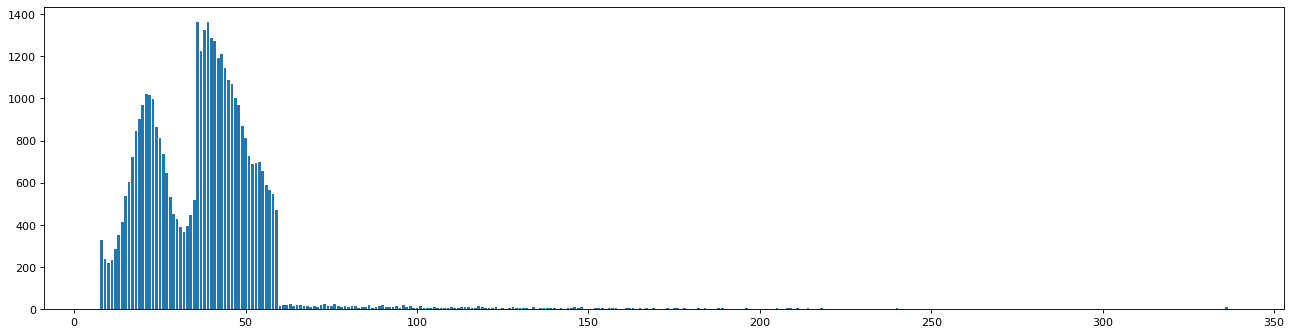

In [60]:
plt.figure(figsize=(20, 5), dpi=80)
plt.bar(time_length_map.keys(), time_length_map.values())
plt.show() 

In [9]:
# show data check file
'''
Sepsis with 0 is normal, 1 is sepsis
Gender= [0,1] with 0 is male, 1 is female
Thredhold of default age is 50 with True is age > 50 and False is age <=50
'''
print('setB 文件信息')
check_df = pd.read_csv(CHECKDATA_DIR+'/check_setB.csv')
check_df.head()

setB 文件信息


,FileName,TypeSepsis,Sex,Age,StartTime,LenTime
0,p100001.psv,0,1,72,24,NaN
1,p100002.psv,0,1,82,25,NaN
2,p100003.psv,0,1,47,43,NaN
3,p100004.psv,0,1,66,59,NaN
4,p100005.psv,0,1,49,52,NaN


In [10]:
# number of sepsis patients in set B
print('setB 中sepsis个数')
check_df[check_df['TypeSepsis'] == 1].shape[0]

setB 中sepsis个数


1142

## missing value process

In [ ]:
# 插值, 形成新数据
def process_missing_data(data_files,interpolation=False):
    for file in data_files:
        df=pd.read_csv(file,delimiter="|")
        if interpolation==True:
            df = df.interpolate(method='linear').ffill().bfill() 
        df = df.ffill().bfill()
        dirpath, file=os.path.split(file)
        path_save=os.path.join(NEWDATA_DIR,file)
        with open(path_save, 'w') as f:
            df.to_csv(f, encoding='utf-8', header=True, index=False)

In [32]:
#特定特征的患者人群插值
'''
input: patient feature
return: pandas frame
'''
def process_missing_data_(path_check_file = 'data_information/check_setB.csv', path_data_folder = 'raw_data/training_B' , sepsis=0, gender=1, age=0, interpolation=False):

    # Divide data to group 
    df = pd.read_csv(path_check_file)
    df = df[df['TypeSepsis'] == sepsis]
    df = df[df['Sex'] == gender]
    if age == 0:
        df = df[df['Age'] <= 50]
    else:
        df = df[df['Age'] > 50]

    # List file in the group 
    file_names = df['FileName']

    # Concatenate all file to a frame
    len = file_names.shape[0]
    for i in range(len):
        file = os.path.join(path_data_folder, file_names.iloc[i])
        df = pd.read_csv(file, delimiter='|')
        #填充nan
        if interpolation == True:
            df = df.interpolate(method='linear').ffill().bfill() 
        df = df.ffill().bfill()
        df['FileName'] = file_names.iloc[i]
        if i == 0:
            frames = df
        else:
            frames = [frames, df]
            frames = pd.concat(frames)
            
    return frames